In [1]:
import sys, os, copy, time
import random
import numpy as np
import torch
import umap 
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from network_mnist_mnist import EncMNIST, DecMNIST
from gibbs_sampler_ziyi import GibbsSampler
import torch.nn.functional as F
import MNIST_MNIST 
import utils 

from gradient import KLGradient, RecGradient
from torchviz import make_dot

In [2]:
MNIST_PATH = '/home/achint/datasets/MNIST/%s.pt'
joint_dataset_train = MNIST_MNIST.MNIST_MNIST(mnist_pt_path=MNIST_PATH % 'training')
joint_dataset_test = MNIST_MNIST.MNIST_MNIST(mnist_pt_path=MNIST_PATH % 'test')
PATH = "/home/achint/Generative_Modelling/Vanilla_VAE/POISE/state_dicts_gradient"

batch_size = 128
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [3]:
lat1, lat2 = 20, 20
num_mix = 10
n_gibbs_iterations = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

enc_mnist1 = EncMNIST(lat1,num_mix).to(device)
dec_mnist1 = DecMNIST(lat1).to(device)
enc_mnist2 = EncMNIST(lat2,num_mix).to(device)
dec_mnist2 = DecMNIST(lat2).to(device)

In [4]:
class Vanilla_VAE(nn.Module):
    def __init__(self, encoders, decoders, latent_dims,num_mix, batch_size=batch_size):
        super(Vanilla_VAE,self).__init__()
        self.lat_dim1 = latent_dims[0]
        self.lat_dim2 = latent_dims[1]
        self.batch_size = batch_size
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(decoders)
        self.gibbs  = GibbsSampler([self.lat_dim1, self.lat_dim2], 'nu')  
#         self.kl_div = KLDDerivative([self.lat_dim1, self.lat_dim2], reduction='mean', enc_config='nu')
        self.num_mix = num_mix
        prior_mean1 = []
        prior_std1  = []
        g11 = []
        g22 = []
        g12 = []
        g21 = []
        for i in range(self.num_mix):
            prior_mean1.append(nn.Parameter(torch.randn(self.lat_dim1)))
            prior_std1.append(nn.Parameter(torch.exp(0.5*torch.randn(self.lat_dim1))))
            g11.append(nn.Parameter(torch.randn(self.lat_dim1,self.lat_dim2)))
            g22.append(nn.Parameter(torch.randn(self.lat_dim1,self.lat_dim2)))
            g12.append(nn.Parameter(torch.randn(self.lat_dim1,self.lat_dim2)))
            g21.append(nn.Parameter(torch.randn(self.lat_dim1,self.lat_dim2)))
            
        self.prior_mean1 = nn.ParameterList(prior_mean1)
        self.prior_std1 = nn.ParameterList(prior_std1)
        self.g11 = nn.ParameterList(g11)
        self.g22 = nn.ParameterList(g22) 
        self.g12 = nn.ParameterList(g12)
        self.g21 = nn.ParameterList(g21) 
        self.register_parameter(name='w_0', param = nn.Parameter(torch.ones(self.batch_size,self.num_mix)))

    def sample_gumbel(self,shape, eps=1e-20):
        U = torch.rand(shape).to(device)
        return -torch.log(-torch.log(U + eps) + eps)


    def gumbel_softmax_sample(self,logits, temperature):
        y = logits + self.sample_gumbel(logits.size())
        return F.softmax(y / temperature, dim=-1)
    def gumbel_softmax(self,logits, temperature, hard=False):
        """
        ST-gumple-softmax
        input: [*, n_class]
        return: flatten --> [*, n_class] an one-hot vector
        """
        y = self.gumbel_softmax_sample(logits, temperature)
        if not hard:
            return y.view(-1, self.num_mix)

        shape = y.size()
        _, ind = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1, shape[-1])
        y_hard.scatter_(1, ind.view(-1, 1), 1)
        y_hard = y_hard.view(*shape)
        # Set gradients w.r.t. y_hard gradients w.r.t. y
        y_hard = (y_hard - y).detach() + y
        return y_hard.view(-1, self.latent_dim_mnist * self.num_mix)
    
    def encode(self, x):
        param1, param2 = [],[]
        weights = self.w_0
        param3 = 0
        for i, xi in enumerate(x):
            if xi is None:
                param1.append(None)
                param2.append(None)
                param3 += torch.tensor(0)
            else:
                ret = self.encoders[i](x[i].view(self.batch_size, -1)) 
                param1.append(ret[0])
                param2.append(ret[1])
                param3 = param3 + ret[2]
        weights = self.gumbel_softmax(torch.log(weights)+param3, 1)
        return param1, param2, weights
    
    def get_G(self, g11,g12_hat,g21_hat,g22_hat):
        g22 = -torch.exp(g22_hat)
        g12 = 2 / np.sqrt(self.lat_dim1) * \
              torch.exp(g22_hat / 2 + torch.log(torch.tensor(0.5)) / 2) * \
              torch.tanh(g12_hat) * 0.99
        g21 = 2 / np.sqrt(self.lat_dim2) * \
              torch.exp(g22_hat / 2 + torch.log(torch.tensor(0.5)) / 2) * \
              torch.tanh(g21_hat) * 0.99
        G = torch.cat((torch.cat((g11, g12), 1), torch.cat((g21, g22), 1)), 0)
        return G
    
    def decode(self, z, x):
        x_rec = []
        neg_loglike = []
        mse_loss = nn.MSELoss(reduction='sum')

        for i, xi in enumerate(z):
            ret = self.decoders[i](xi)
            rec_loss = mse_loss(ret, x[i].view(-1, 784)) if x is not None else torch.zeros_like(ret)
            neg_loglike.append(rec_loss)
            x_rec.append(ret)
        return x_rec, neg_loglike

    
#     def loss_function(self,x_rec, x, kl):
#         mse_loss = nn.MSELoss(reduction='sum')
#         mod_1, mod_2 = x[0],x[1]
#         if ((mod_1 is None) and (mod_2 is None)):
#             MSE = 0
#         elif ((mod_1 is None) and (mod_2 is not None)):                    
#             MSE = mse_loss(x_rec[1],x[1].view(self.batch_size,-1))
#         elif ((mod_1 is not None) and (mod_2 is None)):                    
#             MSE = mse_loss(x_rec[0],x[0].view(self.batch_size,-1))
#         else:
#             MSE = mse_loss(x_rec[0],x[0].view(self.batch_size,-1))+mse_loss(x_rec[1],x[1].view(self.batch_size,-1))
# #         KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#         KLD = kl
#         total_loss = MSE+KLD
#         return total_loss, MSE,KLD
    def _sampling_gradient(self, G, param1, param2, n_iterations):
        with torch.no_grad():
            z_priors, T_priors = self.gibbs.sample(G.detach(), batch_size=batch_size, n_iterations=n_iterations)
            z_posteriors, T_posteriors = self.gibbs.sample(G, nu1=param1, nu2=param2, 
                                                           batch_size=batch_size,
                                                           n_iterations=n_iterations)
            nu = torch.cat([param1[0], param2[0]], -1) if param1[0] is not None else \
                 torch.zeros(T_posteriors[0].shape[0], T_posteriors[0].shape[2]).to(self._dummy.device)
            nup = torch.cat([param1[1], param2[1]], -1) if param1[1] is not None else \
                  torch.zeros(T_posteriors[1].shape[0], T_posteriors[1].shape[2]).to(self._dummy.device)
                
        return z_priors, z_posteriors, T_priors, T_posteriors, [nu, nup]
    def forward(self, x,kl_weight, n_gibbs_iter):
        param1, param2, weights = self.encode(x)
        z1_cluster = []
        z2_cluster = []
#         kl = 0
        for j in range(self.num_mix):

            G = self.get_G(self.g11[j],self.g12[j],self.g21[j],self.g22[j])
            z_priors, T_priors = self.gibbs.sample(G, batch_size=batch_size, n_iterations=n_gibbs_iter)
            mod_1, mod_2 = x[0],x[1]
            if ((mod_1 is None) and (mod_2 is None)):
                param1_out = [None,None]
                param2_out = [None,None]
            elif ((mod_1 is None) and (mod_2 is not None)):                    
                param1_out = [None,param1[1][j]]
                param2_out = [None,-torch.exp(param2[1][j])]
            elif ((mod_1 is not None) and (mod_2 is None)):                    
                param1_out=[param1[0][j],None]
                param2_out = [-torch.exp(param2[0][j]),None]
            else:
                param1_out = [param1[0][j],param1[1][j]]
                param2_out = [-torch.exp(param2[0][j]), -torch.exp(param2[1][j]) ]
            
            z1_posterior = torch.randn(self.batch_size,self.lat_dim1).to(device)
            z2_posterior = torch.randn(self.batch_size,self.lat_dim2).to(device)
            (z_priors, z_posteriors, 
             T_priors, T_posteriors, nus) = self._sampling_gradient(G, param1_out, param2_out, 
                                                                    n_iterations=n_gibbs_iter)
            kl = KLGradient.apply(*T_priors, *T_posteriors, G, *nus)
            z1_cluster.append(z_posteriors[0][:,-1,:])
            z2_cluster.append(z_posteriors[1][:,-1,:])            
        z1_out = 0
        z2_out = 0
        for j in range(self.num_mix):
            z1_out += weights[:, j].unsqueeze(1) * z1_cluster[j]
            z2_out += weights[:, j].unsqueeze(1) * z2_cluster[j]
        z_both = [z1_out,z2_out]
        x_rec, neg_loglike = self.decode(z_both, x)
        
        if all(xi is None for xi in x): # No rec loss
            total_loss = kl
            rec_loss = [0] *2
            kl_loss  = kl
        else:
            rec_loss = [i.detach().mean().item() for i in neg_loglike]
            kl_loss  = kl
            dec_rec_loss = sum(neg_loglike)
            total_loss = kl + dec_rec_loss.mean()
            total_loss += RecGradient.apply(*T_posteriors, G, *nus, dec_rec_loss.detach())
        
#         total_loss, rec_loss,kl_loss = self.loss_function(x_rec, x, kl)

        results = {'data':x,'x_rec': x_rec,
        'total_loss': total_loss, 'rec_losses': rec_loss, 'KL_loss': kl_loss,'z_both':z_both}
        return results

In [5]:
vae = Vanilla_VAE([enc_mnist1, enc_mnist2], [dec_mnist1, dec_mnist2], latent_dims=[lat1, lat2],
                  num_mix=num_mix,batch_size=batch_size).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
# vae, _, epoch = utils.load_checkpoint(vae, load_path=os.path.join(PATH, 'training_45.pt'))
# for name, para in vae.named_parameters():
#     print(name)

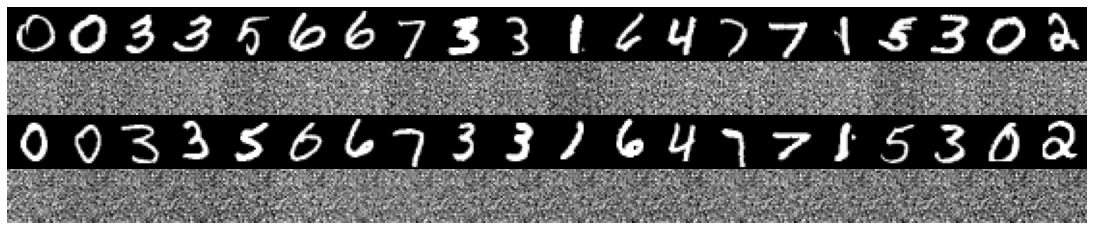

In [6]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].reshape(128,1,28,28).to(device, dtype=torch.float32), data[1].reshape(128,1,28,28).to(device, dtype=torch.float32)],kl_weight=1, n_gibbs_iter=n_gibbs_iterations)
        break
x_rec = [results['x_rec'][0],results['x_rec'][1]]
utils.plotting(vae, data, x_rec)

In [7]:
epoch  = 0
epochs = 100 + epoch
tot_loss_epoch = np.zeros(epochs)
rec_loss_epoch = np.zeros(epochs)
KL_loss_epoch  = np.zeros(epochs)
for epoch in tqdm(range(epoch, epochs)):
    results = utils.train(vae,train_loader,optimizer,kl_weight=1, n_gibbs_iter=n_gibbs_iterations)
    if (epoch+1) % 5 == 0 and epoch > 0:
        utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1) 

    tot_loss_epoch[epoch] = results['total_loss'].cpu()
    rec_loss_epoch[epoch] = results['rec_losses'].cpu()
    KL_loss_epoch[epoch]  = results['KL_loss'].cpu()

  0%|                                                                                                                                  | 0/100 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)